# 0. set data path

In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/transformer/data/'

# 1. Data Preparation

## 1.1 Data cleaning and preprocessing

In [ ]:
!pip install transformers

In [ ]:
# Load libraries
import pandas as pd
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import cohen_kappa_score
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.nn.functional import softmax
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# dataset
fake = pd.read_csv(data_path + "raw_data/Fake.csv")
true = pd.read_csv(data_path + "raw_data/True.csv")
# add label
fake["label"] = 0
true["label"] = 1
# merge into 1 dataset
df = pd.concat([fake, true], axis=0).reset_index(drop=True)

In [ ]:
###NEW###
# recategorize fake news label
# gov, middleeast, us = worldnews
# news, left, potics = politicsNews
df.loc[df['label'] == 0, 'subject'] = df.loc[df['label'] == 0, 'subject'].replace({
    'Government News': 'worldnews',
    'Middle-east': 'worldnews',
    'US_News': 'worldnews',
    'News': 'politicsNews',
    'left-news': 'politicsNews',
    'politics': 'politicsNews'
})

# check
df[df['label'] == 0]['subject'].value_counts()

,count
subject,
politicsNews,20350
worldnews,3131


In [ ]:
# remove xxx(Reuters)- from texts in worldnews and politicsnews


def remove_reuters_prefix(text):
    # match patterns like: "location (Reuters) - "
    # example: "SEATTLE/WASHINGTON (Reuters) -"
    # example: "WEST PALM BEACH, Fla./WASHINGTON (Reuters) -"
    return re.sub(r"^.*?\(Reuters\)\s*-\s*", "", text)

mask = df['subject'].str.lower().isin(['worldnews', 'politicsnews'])

df.loc[mask, 'removed_text'] = df.loc[mask, 'text'].apply(remove_reuters_prefix)

# compare removed and old version
df.loc[mask, ['text', 'removed_text']].head(-10)

,text,removed_text
0,Donald Trump just couldn t wish all Americans ...,Donald Trump just couldn t wish all Americans ...
1,House Intelligence Committee Chairman Devin Nu...,House Intelligence Committee Chairman Devin Nu...
2,"On Friday, it was revealed that former Milwauk...","On Friday, it was revealed that former Milwauk..."
3,"On Christmas day, Donald Trump announced that ...","On Christmas day, Donald Trump announced that ..."
4,Pope Francis used his annual Christmas Day mes...,Pope Francis used his annual Christmas Day mes...
...,...,...
44883,ON BOARD A U.S. MILITARY AIRCRAFT (Reuters) - ...,The U.S. Air Force may intensify its strikes i...
44884,WASHINGTON (Reuters) - The United States sugge...,The United States suggested on Tuesday it coul...
44885,WASHINGTON (Reuters) - The United States has d...,The United States has decided to deny Egypt $9...
44886,ISLAMABAD (Reuters) - Outlining a new strategy...,Outlining a new strategy for the war in Afghan...


In [ ]:
df.shape

(44898, 6)

In [ ]:
# cleaning
df.drop_duplicates(inplace=True)
df.dropna(subset=['title', 'removed_text'], inplace=True)
# preprocess
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = ' '.join([lemmatizer.lemmatize(word)
                     for word in text.split()
                     if word not in stop_words])
    return text

df["clean_text"] = df["removed_text"].apply(clean_text)

In [ ]:
df.shape

(40247, 7)

In [ ]:
#filter na and ' ' -- added by Mia
df = df[df['clean_text'].notna()]
df = df[df['clean_text'].astype(str).str.strip() != '']

In [ ]:
df.shape

(39740, 7)

## 1.2 Exploratory data analysis

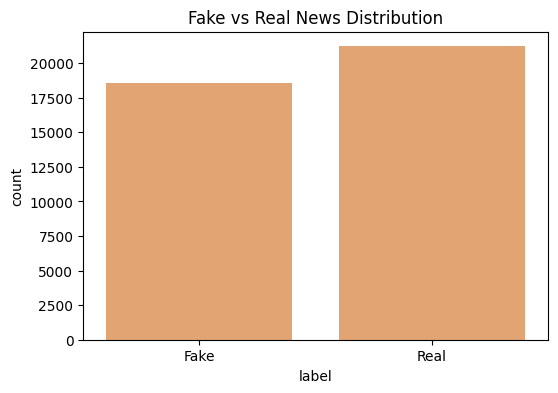

In [ ]:
# label distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df,color='#f4a261')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.title("Fake vs Real News Distribution")
plt.show()

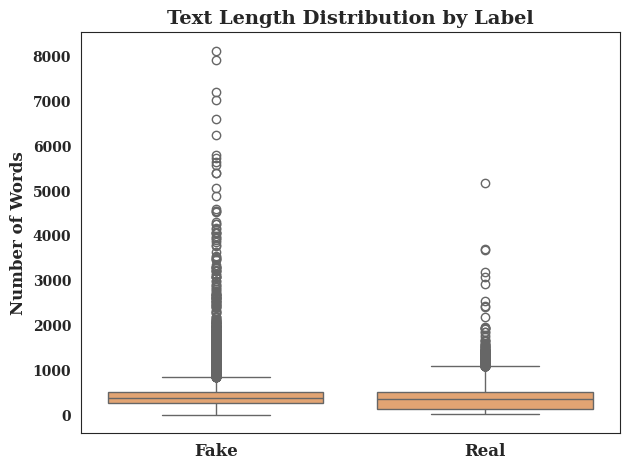

In [ ]:
# text length distribution
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
sns.set_style("white")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.weight'] = 'bold'
sns.boxplot(x='label', y='text_length', data=df, color='#f4a261')
plt.title('Text Length Distribution by Label', fontweight='bold', fontsize=14)
plt.xticks([0, 1], ['Fake', 'Real'], rotation=0, fontsize=12)
plt.ylabel('Number of Words', fontsize=12,fontweight='bold')
plt.xlabel('')
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
# Rename columns appropriately
df = df.rename(columns={'text': 'old_text', 'removed_text': 'text'})
df.loc[mask, ['old_text', 'text']].tail(10)

,old_text,text
44887,GENEVA (Reuters) - North Korea and the United ...,North Korea and the United States clashed at a...
44888,"SAO PAULO (Reuters) - Cesar Mata Pires, the ow...","Cesar Mata Pires, the owner and co-founder of ..."
44890,GENEVA (Reuters) - North Korea and the United ...,North Korea and the United States accused each...
44891,COPENHAGEN (Reuters) - Danish police said on T...,Danish police said on Tuesday the size of a he...
44892,UNITED NATIONS (Reuters) - Two North Korean sh...,Two North Korean shipments to a Syrian governm...
44893,BRUSSELS (Reuters) - NATO allies on Tuesday we...,NATO allies on Tuesday welcomed President Dona...
44894,"LONDON (Reuters) - LexisNexis, a provider of l...","LexisNexis, a provider of legal, regulatory an..."
44895,MINSK (Reuters) - In the shadow of disused Sov...,In the shadow of disused Soviet-era factories ...
44896,MOSCOW (Reuters) - Vatican Secretary of State ...,Vatican Secretary of State Cardinal Pietro Par...
44897,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,Indonesia will buy 11 Sukhoi fighter jets wort...


<ipython-input-18-f18b353f7b7b>:5: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#f4a261'` for the same effect.

  sns.countplot(y='subject', data=df, hue='label_text', order=df['subject'].value_counts().index,color='#f4a261')


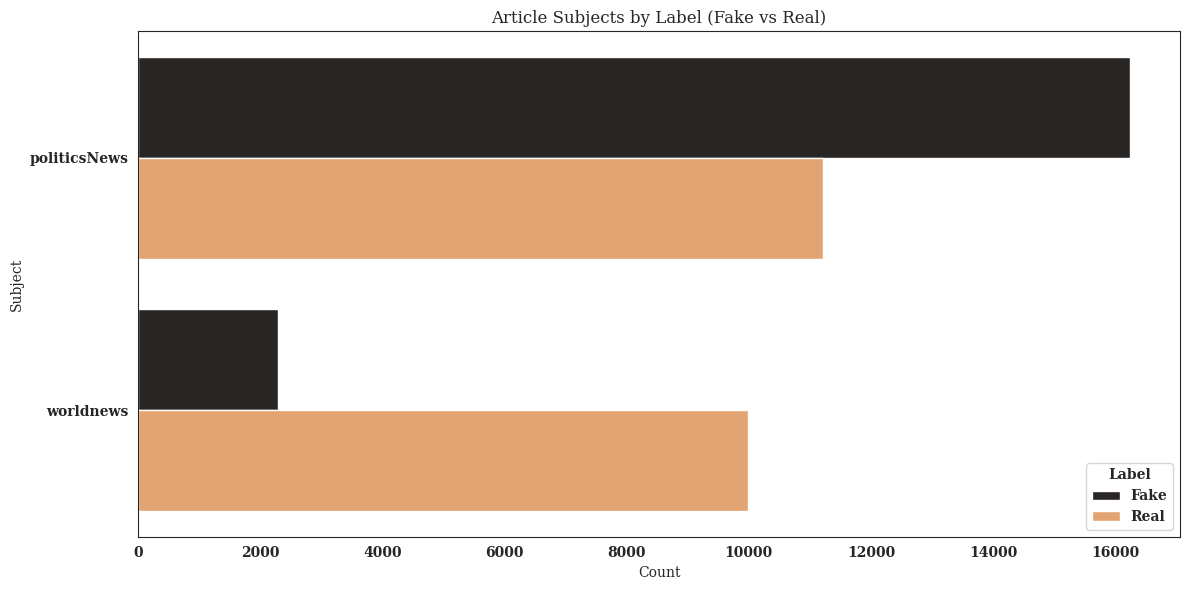

In [ ]:
# subject distribution
if 'subject' in df.columns:
    plt.figure(figsize=(12, 6))
    df['label_text'] = df['label'].map({0: 'Fake', 1: 'Real'})
    sns.countplot(y='subject', data=df, hue='label_text', order=df['subject'].value_counts().index,color='#f4a261')

    plt.title("Article Subjects by Label (Fake vs Real)")
    plt.xlabel("Count")
    plt.ylabel("Subject")
    plt.legend(title="Label")
    plt.tight_layout()
    plt.show()

## 1.3 Sentiment analysis

In [ ]:
# VADER (used to compare with Roberta)
# VADER uses lexicon-based method to categorize,
# meaning Roberta is supposed to be more robust becuase it understand more context, more sentence strcuture etc
#maybe we treat it as a baseline to examine our Roberta
!pip install vaderSentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment_scores(text):
    scores = analyzer.polarity_scores(text)
    return pd.Series([scores['neg'], scores['neu'], scores['pos'], scores['compound']])

In [ ]:
# Apply on raw text or cleaned version
# Vader is non-transformer so i use cleaned text
df[['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']] = df['clean_text'].astype(str).apply(get_vader_sentiment_scores)
def label_vader_sentiment(compound):
    if compound >= 0.05:
        return "positive"
    elif compound <= -0.05:
        return "negative"
    else:
        return "neutral"

df['vader_sentiment_label'] = df['vader_compound'].apply(label_vader_sentiment)

In [ ]:
# load model - Roberta
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name) ## deleted "from_tf=True" by Mia
model = model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

labels = ['negative', 'neutral', 'positive']

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

In [ ]:
# get sentiment
def batch_sentiment_analysis(texts, batch_size=32):
    sentiments = []
    device = next(model.parameters()).device

    for i in tqdm(range(0, len(texts), batch_size), desc="Running sentiment in batches"):
        batch = texts[i:i+batch_size]
        encoded = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)

        with torch.no_grad():
            outputs = model(**encoded)
            probs = softmax(outputs.logits, dim=1).cpu().numpy() #updated this line by Mia

        for prob in probs:
            max_index = np.argmax(prob)
            label = labels[max_index]  # 'negative', 'neutral', or 'positive'
            sentiments.append({
                "negative": prob[0],
                "neutral": prob[1],
                "positive": prob[2],
                "sentiment_label": label  # updated by Mia
            })

    return sentiments

In [ ]:
texts = df["text"].astype(str).tolist() #using raw texts- by Mia

sentiment_scores = batch_sentiment_analysis(texts, batch_size=32)
sentiment_df = pd.DataFrame(sentiment_scores)
df = pd.concat([df.reset_index(drop=True),
               sentiment_df], axis=1)

Running sentiment in batches: 100%|██████████| 1242/1242 [04:05<00:00,  5.06it/s]


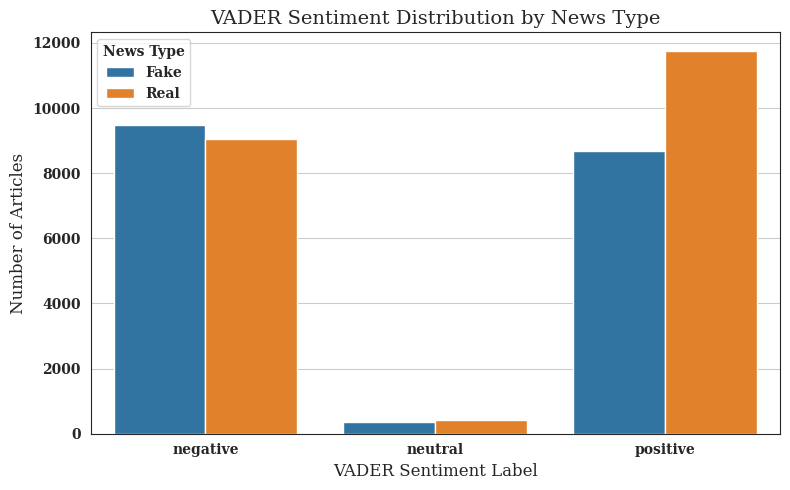

In [ ]:
# vader results
df['label_text'] = df['label'].map({0: 'Fake', 1: 'Real'})

# Count sentiment label distribution grouped by news label
vader_sentiment_counts = df.groupby(['label_text', 'vader_sentiment_label'])['vader_sentiment_label'].count().reset_index(name='count')

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=vader_sentiment_counts, x='vader_sentiment_label', y='count', hue='label_text')
plt.title("VADER Sentiment Distribution by News Type", fontsize=14)
plt.xlabel("VADER Sentiment Label", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.legend(title="News Type")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


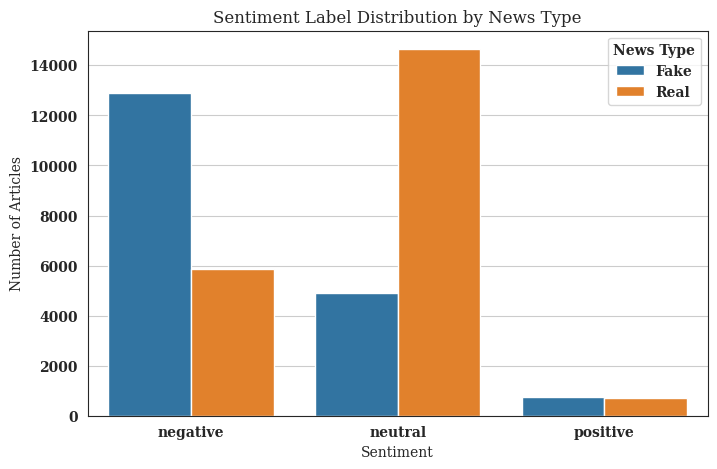

In [ ]:
# Roberta results
sentiment_counts = df.groupby(['label', 'sentiment_label'])['sentiment_label'].count().reset_index(name='count')
sentiment_counts['label'] = sentiment_counts['label'].map({0: 'Fake', 1: 'Real'})
plt.figure(figsize=(8, 5))
sns.barplot(data=sentiment_counts, x="sentiment_label", y="count", hue="label") # Changed 'news_label' to 'label'
plt.title("Sentiment Label Distribution by News Type")
plt.xlabel("Sentiment")
plt.ylabel("Number of Articles")
plt.legend(title="News Type")
plt.grid(axis='y')
plt.show()

In [ ]:
# compare the agreement on distribution of sentiment labels between ROberta and VADER
from sklearn.metrics import cohen_kappa_score
roberta_labels = df['sentiment_label'].astype(str)
vader_labels = df['vader_sentiment_label'].astype(str)
kappa_score = cohen_kappa_score(roberta_labels, vader_labels)
print(f"Cohen's Kappa Agreement Score between RoBERTa and VADER: {kappa_score:.4f}")
# they only have slight agreement on each other

Cohen's Kappa Agreement Score between RoBERTa and VADER: 0.1672


In [ ]:
# manually checking on the disagreement between 2 models
#pd.set_option('display.max_colwidth', None)
#disagreements = df[df['sentiment_label'] != df['vader_sentiment_label']]
#disagreements[['text', 'sentiment_label', 'vader_sentiment_label']].head()


In [ ]:
# VADER: evaluate
# VADER
X_vader = df[['vader_neg', 'vader_neu', 'vader_pos']]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X_vader, y, test_size=0.2, random_state=42)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("VADER- Fake News Classification:")
print(classification_report(y_test, y_pred))

VADER- Fake News Classification:
              precision    recall  f1-score   support

           0       0.62      0.54      0.58      3706
           1       0.64      0.71      0.67      4242

    accuracy                           0.63      7948
   macro avg       0.63      0.63      0.63      7948
weighted avg       0.63      0.63      0.63      7948



              precision    recall  f1-score   support

        Fake       0.72      0.69      0.70      3706
        Real       0.74      0.76      0.75      4242

    accuracy                           0.73      7948
   macro avg       0.73      0.72      0.73      7948
weighted avg       0.73      0.73      0.73      7948



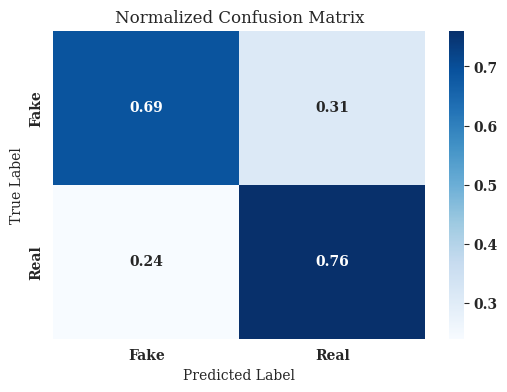

In [ ]:
# Roberta: evaluate sentiment labels
X = df[["negative", "neutral", "positive"]]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["Fake", "Real"]))

# confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 4))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
df.to_csv(data_path +"derived_data/df_with_sa.csv", index=False)

## 1.4 Named Entity Recognition

In [ ]:
import pandas as pd
df = pd.read_csv(data_path +"derived_data/df_with_sa.csv")

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 115.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy
import pandas as pd
from tqdm import tqdm

nlp = spacy.load("en_core_web_sm")

In [ ]:
df['full_text'] = df['title'] + ". " + df['text']
allowed_labels = ['ORG', 'GPE', 'PERSON', 'PRODUCT', 'LOC', 'NORP', 'EVENT', 'DATE']

In [ ]:
def extract_named_entities(texts, allowed_labels=None):
    if allowed_labels is None:
        allowed_labels = ['ORG', 'GPE', 'PERSON']
    results = []
    for doc in nlp.pipe(texts, batch_size=32, n_process=1):
        entities = [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in allowed_labels]
        results.append(entities)
    return results

tqdm.pandas()
df['named_entities'] = extract_named_entities(df['full_text'].tolist(), allowed_labels=allowed_labels)

In [ ]:
# Format entity output
def format_entities(entity_list):
    if not entity_list:
        return "None"
    formatted = [f"{text} ({label})" for text, label in entity_list]
    return ", ".join(formatted)

df['entities_str'] = df['named_entities'].apply(format_entities)

In [ ]:
df.to_csv(data_path +"derived_data/df_with_sa&ner.csv", index=False)

In [ ]:
df[['named_entities','entities_str']].head()

,named_entities,entities_str
0,"[(Donald Trump Sends Out, PERSON), (Embarrassi...","Donald Trump Sends Out (PERSON), Embarrassing ..."
1,"[(Russian Collusion Investigation, ORG), (Hous...","Russian Collusion Investigation (ORG), House I..."
2,"[(David Clarke, PERSON), (Friday, DATE), (Milw...","David Clarke (PERSON), Friday (DATE), Milwauke..."
3,"[(Obama’s Name Coded Into His Website, ORG), (...","Obama’s Name Coded Into His Website (ORG), IMA..."
4,"[(Donald Trump, PERSON), (Christmas, DATE), (P...","Donald Trump (PERSON), Christmas (DATE), Pope ..."


In [ ]:
import matplotlib.pyplot as plt

# Extract the named entities and their labels
entity_counts = {}

# Loop through the dataset
for index, row in df.iterrows():
    news_label = row['label_text']  # The label indicating real or fake
    entities = row['named_entities']

    if news_label not in entity_counts:
        entity_counts[news_label] = {}

    for entity, label in entities:
        if label not in entity_counts[news_label]:
            entity_counts[news_label][label] = 0
        entity_counts[news_label][label] += 1

# Convert the counts to a DataFrame for visualization
counts_df = pd.DataFrame.from_dict(entity_counts, orient='index').fillna(0).astype(int)
counts_df = counts_df.transpose()  # Transpose for easier plotting


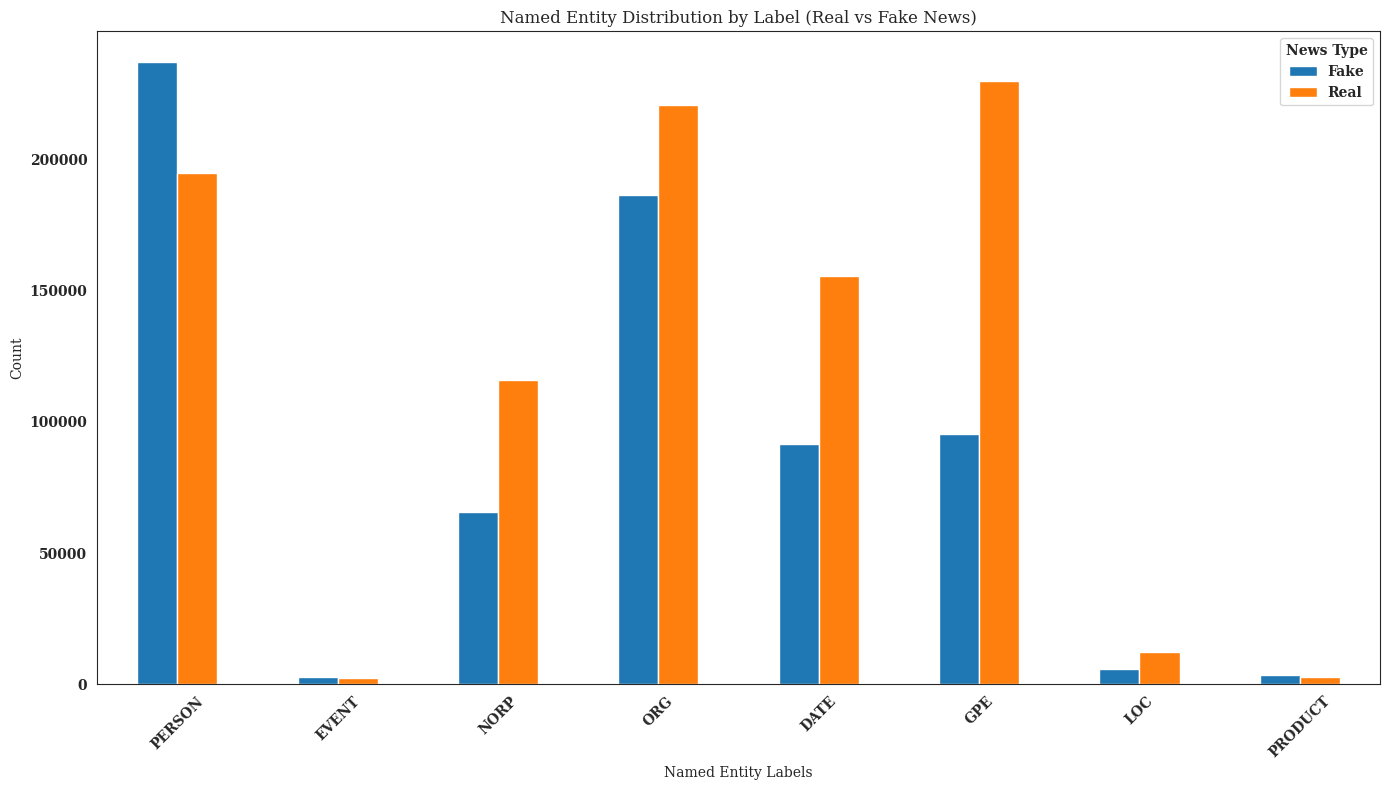

In [ ]:
# Plotting bar plots for comparison
counts_df.plot(kind='bar', figsize=(14, 8))
plt.title('Named Entity Distribution by Label (Real vs Fake News)')
plt.xlabel('Named Entity Labels')
plt.ylabel('Count')
plt.legend(title='News Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 1.5 Linguistic Features Extraction

In [ ]:
import pandas as pd
df = pd.read_csv(data_path +"derived_data/df_with_sa&ner.csv")

In [ ]:
!pip install -U "spacy[cuda12.4]"
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install textstat tqdm pandas
!python -m spacy download en_core_web_trf

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 3.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy
import pandas as pd
import re
from tqdm import tqdm
from textstat import flesch_reading_ease

In [ ]:
# Enable GPU before loading models
spacy.prefer_gpu()  # or spacy.require_gpu() for mandatory GPU usage

def process_linguistic_features(df):
    # Load transformer-based model (better for GPU)
    nlp = spacy.load(
        "en_core_web_trf",
        disable=["parser", "ner", "lemmatizer", "textcat"]
    )

    texts = df['full_text'].tolist()
    features = []

    # Process in optimized batches
    batch_size = 128  # Adjust based on GPU memory (start with 64-256)
    for doc in tqdm(nlp.pipe(texts, batch_size=batch_size),
                    total=len(texts),
                    desc="GPU Processing"):
        features.append(extract_features(doc))

    return pd.concat([df, pd.DataFrame(features)], axis=1)

def extract_features(doc):
    # Extract features from pre-processed Doc object
    alpha_tokens = [t.text for t in doc if t.is_alpha]
    word_count = len(alpha_tokens)
    unique_words = set(token.text.lower() for token in doc if token.is_alpha)
    lexical_diversity = len(unique_words) / word_count if word_count > 0 else 0

    # Readability
    readability = flesch_reading_ease(doc.text)

    # Punctuation/formatting
    text_content = doc.text
    exclamation_count = text_content.count("!")
    question_count = len(re.findall(r"\?", text_content))
    uppercase_ratio = sum(1 for c in text_content if c.isupper()) / len(text_content) if text_content else 0


    # POS ratios (now using vectorized operations)
    noun_count = sum(1 for t in doc if t.pos_ == "NOUN")
    verb_count = sum(1 for t in doc if t.pos_ == "VERB")
    pron_count = sum(1 for t in doc if t.pos_ == "PRON")

    return {
        'word_count': word_count,
        'noun_ratio': noun_count/len(doc),
        'verb_ratio': verb_count/len(doc),
        'pronoun_ratio': pron_count/len(doc),
        'lexical_diversity': lexical_diversity,
        'flesch_reading': readability,
        'exclamation_count': exclamation_count,
        'question_count': question_count,
        'uppercase_ratio': uppercase_ratio
    }
df = process_linguistic_features(df)

/usr/local/lib/python3.11/dist-packages/thinc/shims/pytorch.py:261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filelike, map_location=dev

In [ ]:
nlp_grammar = spacy.load("en_core_web_sm", disable=["parser", "ner", "lemmatizer"])
nlp_grammar.add_pipe("sentencizer")

In [ ]:
from transformers import pipeline
# GPU-accelerated grammar model
classifier = pipeline(
    "text-classification",
    model="textattack/roberta-base-CoLA",
    device=0,        # Use GPU
    batch_size=256,  # Maximize GPU utilization
    truncation=True  # Handle long texts
)

def get_grammar_errors(text):
    """Returns estimated ungrammatical sentences using GPU model"""
    doc = nlp_grammar(text)
    sentences = [sent.text.strip() for sent in doc.sents if len(sent.text.strip()) > 5]
    if not sentences:
        return 0

    # Batch process sentences on GPU
    results = classifier(sentences)
    return sum(1 for res in results if res['label'] == 'LABEL_0')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at textattack/roberta-base-CoLA were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
tqdm.pandas(desc="Checking grammar (GPU)")
df['grammar_error_count'] = df['full_text'].progress_apply(get_grammar_errors)
df['grammar_error_ratio'] = df['grammar_error_count'] / df['word_count'].replace(0, 1)


Checking grammar (GPU): 100%|██████████| 39740/39740 [29:30<00:00, 22.45it/s]


In [ ]:
df.to_csv(data_path +"derived_data/df_with_sa&ner&lf.csv", index=False)

1.1.5 Exploratory Analysis

In [ ]:
df.head()

,title,old_text,subject,date,label,text,clean_text,text_length,label_text,vader_neg,...,verb_ratio,pronoun_ratio,lexical_diversity,flesch_reading,exclamation_count,question_count,uppercase_ratio,grammar_error_count,grammar_error_ratio,clickbait_extraction
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,politicsNews,"December 31, 2017",0,Donald Trump just couldn t wish all Americans ...,donald trump wish american happy new year leav...,495,Fake,0.194,...,0.083203,0.072214,0.461039,62.88,6,9,0.050101,3,0.006494,no clickbaits
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,politicsNews,"December 31, 2017",0,House Intelligence Committee Chairman Devin Nu...,house intelligence committee chairman devin nu...,305,Fake,0.101,...,0.099448,0.035912,0.597484,46.27,0,0,0.048756,1,0.003145,no clickbaits
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",politicsNews,"December 30, 2017",0,"On Friday, it was revealed that former Milwauk...",friday revealed former milwaukee sheriff david...,580,Fake,0.200,...,0.119342,0.094650,0.490876,63.59,2,4,0.087558,5,0.009124,no clickbaits
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",politicsNews,"December 29, 2017",0,"On Christmas day, Donald Trump announced that ...",christmas day donald trump announced would bac...,444,Fake,0.067,...,0.094643,0.048214,0.531765,53.71,0,1,0.049755,2,0.004706,no clickbaits
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,politicsNews,"December 25, 2017",0,Pope Francis used his annual Christmas Day mes...,pope francis used annual christmas day message...,420,Fake,0.138,...,0.125000,0.077869,0.515012,59.13,0,0,0.030604,0,0.000000,no clickbaits


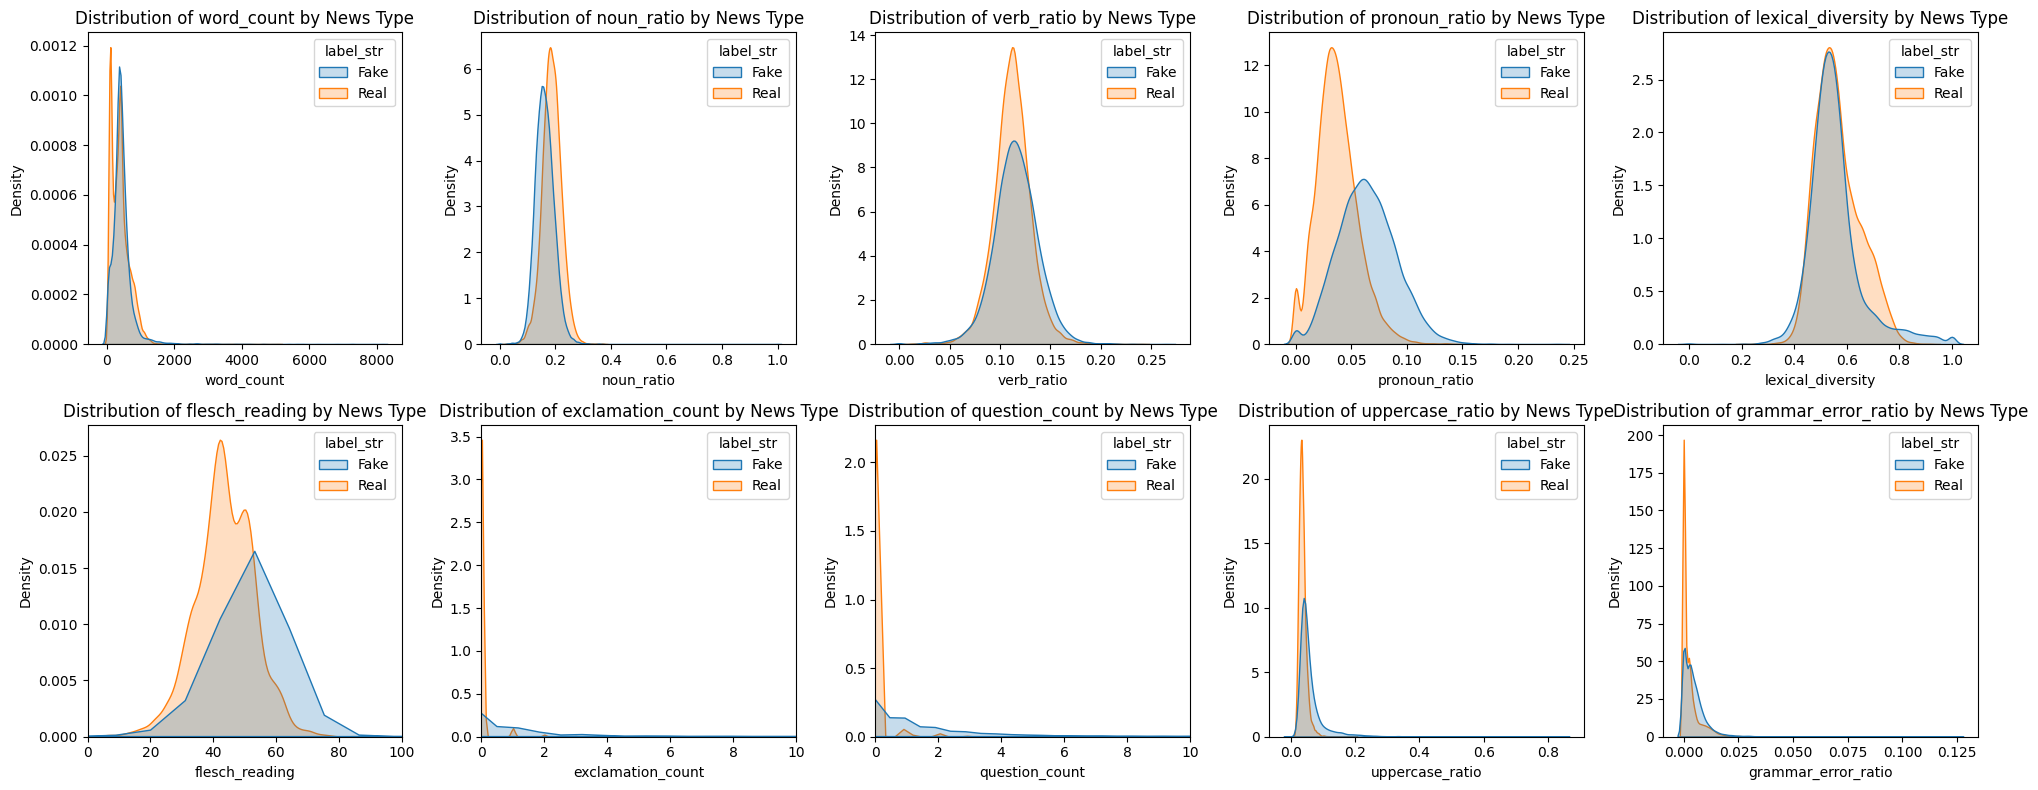

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create string labels
df['label_str'] = df['label'].map({0: 'Fake', 1: 'Real'})

# Define features to analyze
features = ['word_count', 'noun_ratio', 'verb_ratio', 'pronoun_ratio',
            'lexical_diversity', 'flesch_reading', 'exclamation_count',
            'question_count', 'uppercase_ratio', 'grammar_error_ratio']

# Set up the grid of subplots (2 rows, 5 columns)
n_cols = 5
n_rows = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8))
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

# Plot distributions by news type
for i, feature in enumerate(features):
    sns.kdeplot(data=df, x=feature, hue='label_str', fill=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature} by News Type')

    # Set xlim for specific features
    if feature == 'flesch_reading':
        axes[i].set_xlim(0, 100)  # Limit for Flesch Reading
    elif feature == 'exclamation_count' or feature == 'question_count':
        axes[i].set_xlim(0, 10)  # Limit for Exclamation and Question Count

# Remove any unused subplots (in case of extra axes)
for i in range(len(features), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = df[features]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      3706
           1       0.91      0.92      0.92      4242

    accuracy                           0.91      7948
   macro avg       0.91      0.91      0.91      7948
weighted avg       0.91      0.91      0.91      7948



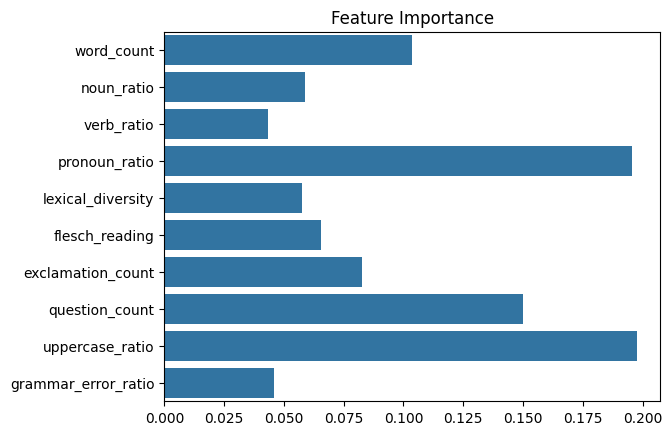

In [ ]:
importances = model.feature_importances_
sns.barplot(x=importances, y=features)
plt.title("Feature Importance")
plt.show()

In [ ]:
summary_stats = df.groupby('label_str')[features].agg(['mean', 'std', 'median', 'min', 'max'])
print(summary_stats.T)  # Transpose for easier reading

label_str                          Fake         Real
word_count          mean     438.242795   385.993164
                    std      357.993146   270.286970
                    median   389.000000   360.000000
                    min        0.000000    27.000000
                    max     8180.000000  5097.000000
noun_ratio          mean       0.160968     0.186261
                    std        0.034383     0.034681
                    median     0.159171     0.185658
                    min        0.000000     0.020408
                    max        1.000000     0.375000
verb_ratio          mean       0.115619     0.111708
                    std        0.022263     0.018734
                    median     0.115338     0.111888
                    min        0.000000     0.011494
                    max        0.264706     0.240741
pronoun_ratio       mean       0.063706     0.036993
                    std        0.026349     0.018673
                    median     0.062615     0.

In [ ]:
# Numeric label for correlation
df['label_num'] = df['label_str'].map({'Real': 0, 'Fake': 1})

correlations = df[features + ['label_num']].corr()['label_num'].sort_values(ascending=False)
print(correlations)


label_num              1.000000
pronoun_ratio          0.508272
question_count         0.333128
uppercase_ratio        0.323738
exclamation_count      0.271609
grammar_error_ratio    0.201997
flesch_reading         0.184460
verb_ratio             0.094972
word_count             0.082665
lexical_diversity     -0.053974
noun_ratio            -0.343118
Name: label_num, dtype: float64


#####
interpretation:
 word count: more words for fake - can be because of source of fake news tho :/

 Fake has more question marks, more pronoun ratio, more uppercase words, more grammar erros, more exclamation, higher
 flesch_reading

 noun ratio more for real;

 verb ratio; lexical diversity and categories pretty similar

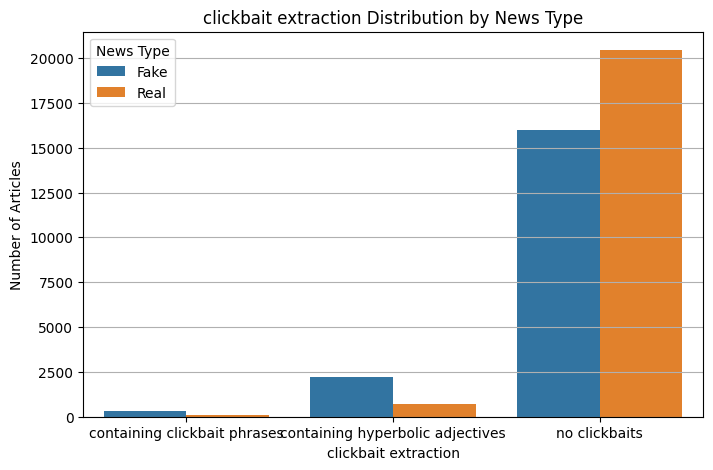

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

clickbait_counts = df.groupby(['label', 'clickbait_extraction'])['clickbait_extraction'].count().reset_index(name='count')
clickbait_counts['label'] = clickbait_counts['label'].map({0: 'Fake', 1: 'Real'})
plt.figure(figsize=(8, 5))
sns.barplot(data=clickbait_counts, x="clickbait_extraction", y="count", hue="label")
plt.title("clickbait extraction Distribution by News Type")
plt.xlabel("clickbait extraction")
plt.ylabel("Number of Articles")
plt.legend(title="News Type")
plt.grid(axis='y')
plt.show()

## 1.6 Topic Modelling(Bertopic)

In [ ]:
import pandas as pd
df = pd.read_csv(data_path + "derived_data/df_with_sa&ner&lf.csv")

In [ ]:
!pip install bertopic umap-learn hdbscan sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 4.3 MB/s eta 0:00:00


In [ ]:
import re

def clean_text_for_topic(text):
    text = re.sub(r'http\S+', '', text)
    return text

df["cleaned_text_for_topic"] = df["full_text"].apply(clean_text_for_topic)

In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired
from bertopic.representation import MaximalMarginalRelevance

In [ ]:
# Choose Embedding Model
embedding_model = SentenceTransformer("all-mpnet-base-v2")

# Tune UMAP(reduce dimensions)
umap_model = UMAP(n_neighbors=10, n_components = 10, metric='cosine', min_dist=0.0, random_state=888)

# Tune HDBSCAN (clustering)
hdbscan_model = HDBSCAN(min_cluster_size=50, min_samples=10, prediction_data=True,)

#Removing stop words
vectorizer_model = CountVectorizer(
    stop_words="english",
    ngram_range=(1,2)
)
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

#Diversify topic representation
representation_model = MaximalMarginalRelevance(diversity=0.1)

topic_model = BERTopic(
    embedding_model= embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    representation_model=representation_model,
    ctfidf_model=ctfidf_model,
    low_memory=True,
    language = "english",
    calculate_probabilities=True,
    verbose=True,
    top_n_words = 10,
    nr_topics=20
)
docs = df["cleaned_text_for_topic"].tolist()
topics, probabilities = topic_model.fit_transform(docs)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2025-04-07 19:10:38,621 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1242 [00:00<?, ?it/s]

2025-04-07 19:14:47,780 - BERTopic - Embedding - Completed ✓
2025-04-07 19:14:47,781 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-07 19:15:54,740 - BERTopic - Dimensionality - Completed ✓
2025-04-07 19:15:54,742 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-07 19:17:10,627 - BERTopic - Cluster - Completed ✓
2025-04-07 19:17:10,629 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-07 19:17:55,477 - BERTopic - Representation - Completed ✓
2025-04-07 19:17:55,650 - BERTopic - Topic reduction - Reducing number of topics
2025-04-07 19:17:55,719 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-07 19:18:41,709 - BERTopic - Representation - Completed ✓
2025-04-07 19:18:41,892 - BERTopic - Topic reduction - Reduced number of topics from 200 to 20


In [ ]:
topic_info = topic_model.get_topic_info()

In [ ]:
topic_model.save("bertopic_model")

2025-04-07 19:19:49,822 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [ ]:
# Add topic information to DataFrame
df['topic_id'] = topics
df['topic_name'] = df['topic_id'].map(topic_model.get_topic_info().set_index('Topic')['Name'])

In [ ]:
df.columns

Index(['title', 'old_text', 'subject', 'date', 'label', 'text', 'clean_text',
       'text_length', 'label_text', 'vader_neg', 'vader_neu', 'vader_pos',
       'vader_compound', 'vader_sentiment_label', 'negative', 'neutral',
       'positive', 'sentiment_label', 'full_text', 'named_entities',
       'entities_str', 'word_count', 'noun_ratio', 'verb_ratio',
       'pronoun_ratio', 'lexical_diversity', 'flesch_reading',
       'exclamation_count', 'question_count', 'uppercase_ratio',
       'grammar_error_count', 'grammar_error_ratio', 'clickbait_extraction',
       'cleaned_text_for_topic', 'topic_id', 'topic_name'],
      dtype='object')

In [ ]:
# Count the number of documents (rows) per topic_id
topic_counts = df.groupby(['topic_id', 'topic_name']).size().reset_index(name='Number of Documents')

# Rename columns for clarity
topic_counts.columns = ['Topic ID','Topic Name','Number of Documents']

# Sort by Topic ID for a clean table
topic_counts = topic_counts.sort_values(by='Topic ID')

# Display the table
topic_counts

,Topic ID,Topic Name,Number of Documents
0,1,-1_trump_president_donald_donald trump,8566
1,2,0_trump_hillary_donald_election,8170
2,3,1_police_black_trump_supreme court,6169
3,4,2_obamacare_senate_republican_healthcare,4815
4,5,3_korea_north korea_china_iran,3593
5,6,4_saudi_myanmar_syria_islamic state,3032
6,7,5_turkey_turkish_erdogan_ankara,814
7,8,6_brexit_britain_ireland_uk,785
8,9,7_merkel_coalition_macron_eu,758
9,10,8_cuba_venezuela_maduro_cuban,742


In [ ]:
# Evaluation 1: Visual inspection
fig1 = topic_model.visualize_topics()
fig1.show()

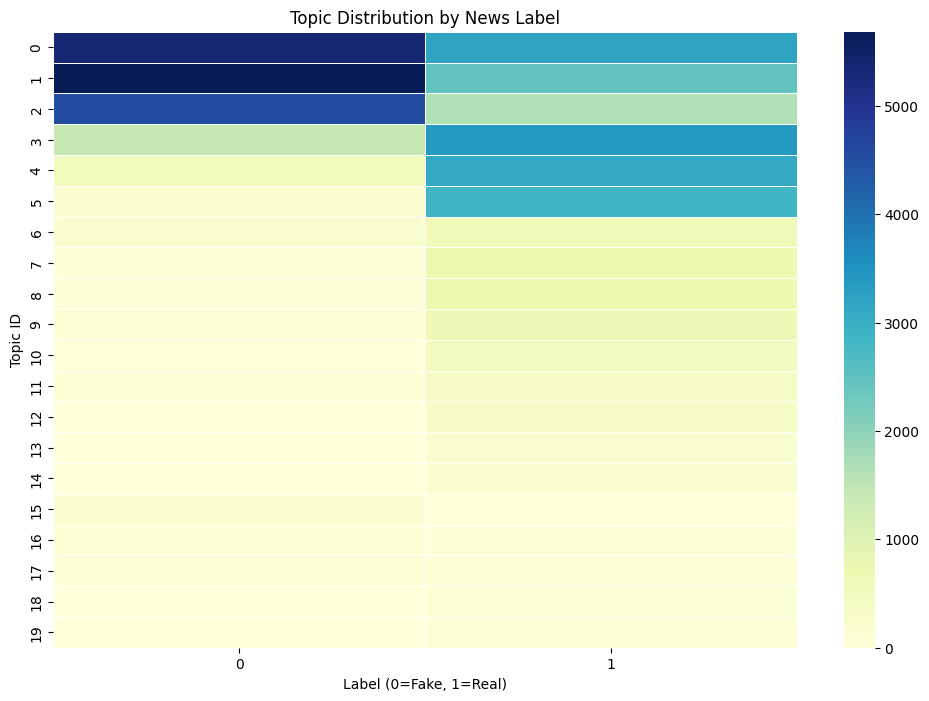

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Evaluation: Topic distribution by label
topic_dist = df.groupby(['label', 'topic_id']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(topic_dist.T, cmap="YlGnBu",
            annot=False, linewidths=.5)
plt.title("Topic Distribution by News Label")
plt.xlabel("Label (0=Fake, 1=Real)")
plt.ylabel("Topic ID")
plt.show()

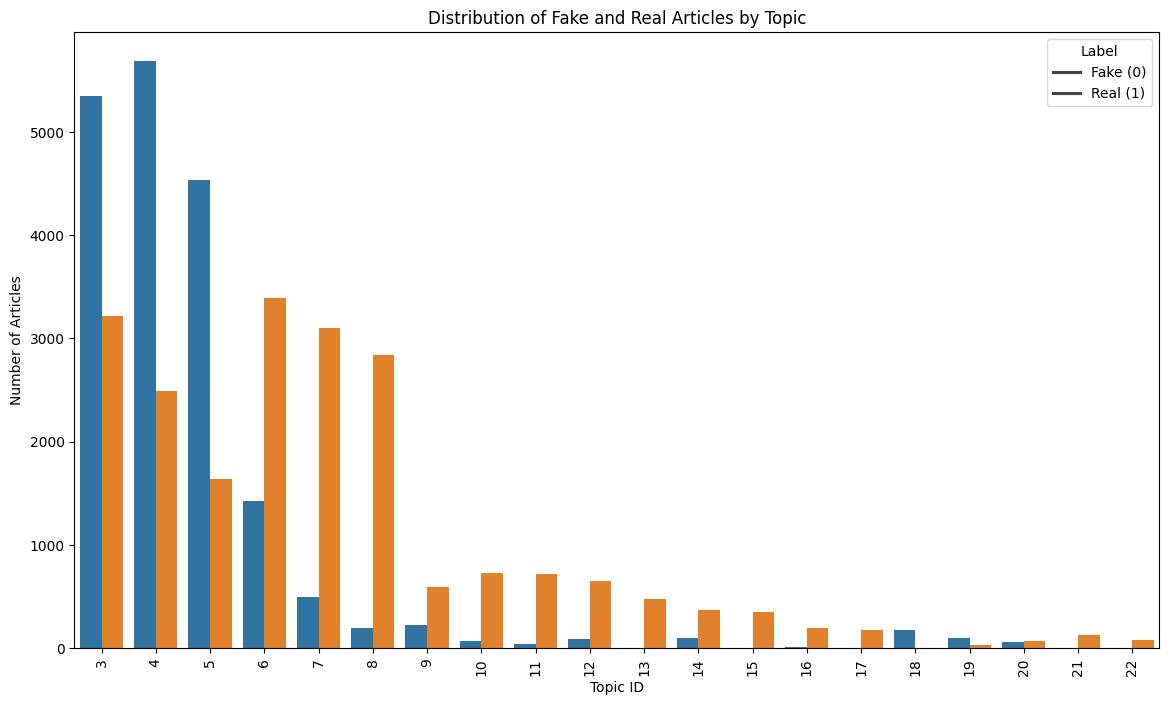

In [ ]:
df['topic_id'] = df['topic_id'] + 1
# Grouping the data by topic_id and label to get counts
topic_label_distribution = df.groupby(['topic_id', 'label']).size().reset_index(name='count')

# Creating the bar plot
plt.figure(figsize=(14, 8))
sns.barplot(data=topic_label_distribution, x='topic_id', y='count', hue='label')

# Adding plot details
plt.title('Distribution of Fake and Real Articles by Topic')
plt.xlabel('Topic ID')
plt.ylabel('Number of Articles')
plt.legend(title='Label', labels=['Fake (0)', 'Real (1)'])
plt.xticks(rotation=90)
plt.show()

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


# Encode topics as numeric categories (excluding -1 if needed)
X = np.array(topics).reshape(-1, 1)

y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=888)

clf = LogisticRegression()
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))


              precision    recall  f1-score   support

           0       0.68      0.84      0.75      3706
           1       0.83      0.65      0.73      4242

    accuracy                           0.74      7948
   macro avg       0.75      0.75      0.74      7948
weighted avg       0.76      0.74      0.74      7948



In [ ]:
df.to_csv(data_path +"derived_data/df_with_all_features.csv", index=False)

# 2. Model Implementation-GPT

In [ ]:
import pandas as pd
df = pd.read_csv(data_path + "derived_data/df_with_all_features.csv")

In [ ]:
pip install openai

In [ ]:
import openai
import pandas as pd

openai.api_key = ""

In [ ]:
def semantic_prompt_with_explanation(row):
    return (
        f"Given the following features of a news article, classify it as 'Fake' or 'Real' and explain your reasoning.\n\n"
        f"Sentiment: negative={row['negative']:.2f}, neutral={row['neutral']:.2f}, positive={row['positive']:.2f}\n"
        f"Topics: {row['topic_name']}\n"
        #f"Subject: {row['subject']}\n"
        f"Exclamation Count: {row['exclamation_count']}\n"
        f"Question Count: {row['question_count']}\n"
        f"Grammar Errors: {row['grammar_error_count']}\n"
        #f"Clickbait Extraction: {row['clickbait_extraction']}\n"
        f"Entities: {row['entities_str']}\n\n"
        f"First state the label on the first line, then give a brief explanation on the next line.\n"
        f"Example:\nFake\nBecause the entities are sensational and sentiment is extremely negative.\n\n"
        f"Your answer:"
    )
#f"Readability: {row['flesch_reading']}\n"
#f"uppercase_ratio: {row['uppercase_ratio']}\n"
#f"Lexical Diversity: {row['lexical_diversity']}\n"
#f"Sentiment: {row['sentiment_label']}\n"
#f"Noun Ratio:{row['noun_ratio']:.3f}\n"
#f"Verb Ratio:{row['verb_ratio']:.3f}\n"
#f"Pronoun Ratio:{row['pronoun_ratio']:.3f}\n"


In [ ]:
def raw_prompt_with_explanation(row):
    return (
        f"Here is a news article:\n\n{row['full_text']}\n\n"
        f"Classify it as 'Fake' or 'Real' and explain your reasoning.\n"
        f"First state the label on the first line, then give a brief explanation on the next line.\n"
        f"Example:\nFake\nBecause the entities are sensational and sentiment is extremely negative.\n\n"
        f"Your answer:"
    )

In [ ]:
def classify_with_gpt_and_explanation(prompt, model="gpt-3.5-turbo"):
    response = openai.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=0,
        max_tokens=100
    )
    full_response = response.choices[0].message.content.strip()

    # Parse label and explanation
    lines = full_response.split("\n", 1)
    label = lines[0].strip().capitalize()
    explanation = lines[1].strip() if len(lines) > 1 else "No explanation returned."

    if "fake" in label.lower():
        label = "Fake"
    elif "real" in label.lower():
        label = "Real"
    else:
        label = label  # fallback

    return label, explanation


In [ ]:
# Sample a few examples
sample_df = df.sample(n=1000, random_state=777).copy()

# prompt:
sample_df["prompt"] = sample_df.apply(raw_prompt_with_explanation, axis=1)


# Get label + explanation
sample_df[["gpt_prediction", "gpt_explanation"]] = sample_df["prompt"].apply(
    lambda p: pd.Series(classify_with_gpt_and_explanation(p))
)
# Evaluate
accuracy = (sample_df["gpt_prediction"].str.lower() == sample_df["label_text"].str.lower()).mean()
print(f"\nGPT Zero-shot Accuracy: {accuracy:.2%}")

sample_df.to_csv(data_path +"derived_data/gpt_predictions_raw.csv", index=False)


GPT Zero-shot Accuracy: 71.30%


In [ ]:
# Sample a few examples
sample_df = df.sample(n=1000, random_state=777).copy()

# prompt:
sample_df["prompt"] = sample_df.apply(semantic_prompt_with_explanation, axis=1)


# Get label + explanation
sample_df[["gpt_prediction", "gpt_explanation"]] = sample_df["prompt"].apply(
    lambda p: pd.Series(classify_with_gpt_and_explanation(p))
)
# Evaluate
accuracy = (sample_df["gpt_prediction"].str.lower() == sample_df["label_text"].str.lower()).mean()
print(f"\nGPT Zero-shot Accuracy: {accuracy:.2%}")

sample_df.to_csv(data_path +"derived_data/gpt_predictions_semantic.csv", index=False)


GPT Zero-shot Accuracy: 72.40%


# More Trials
Removed the ones didnt make a difference like :  noun ratio; verb ratio; lexical diversity; clickbait; subject

In [ ]:
def semantic_prompt_with_explanation_new(row):
    return (
        f"Given the following features of a news article, classify it as 'Fake' or 'Real' and explain your reasoning.\n\n"
        f"Sentiment: negative={row['negative']:.2f}, neutral={row['neutral']:.2f}, positive={row['positive']:.2f}\n"
        f"Topics: {row['topic_name']}\n"
        #f"Subject: {row['subject']}\n"
        f"Exclamation Count: {row['exclamation_count']}\n"
        f"Question Count: {row['question_count']}\n"
        f"Grammar Errors: {row['grammar_error_count']}\n"
        #f"Clickbait Extraction: {row['clickbait_extraction']}\n"
        f"Entities: {row['entities_str']}\n\n"
        f"Pronoun Ratio:{row['pronoun_ratio']:.3f}\n"
        f"Readability: {row['flesch_reading']}\n"
        f"uppercase_ratio: {row['uppercase_ratio']}\n"
        f"First state the label on the first line, then give a brief explanation on the next line.\n"
        f"Example:\nFake\nBecause the entities are sensational and sentiment is extremely negative.\n\n"
        f"Your answer:"
    )


In [ ]:
# Sample a few examples
sample_df = df.sample(n=1000, random_state=777).copy()

# prompt:
sample_df["prompt"] = sample_df.apply(semantic_prompt_with_explanation_new, axis=1)


# Get label + explanation
sample_df[["gpt_prediction", "gpt_explanation"]] = sample_df["prompt"].apply(
    lambda p: pd.Series(classify_with_gpt_and_explanation(p))
)
# Evaluate
accuracy = (sample_df["gpt_prediction"].str.lower() == sample_df["label_text"].str.lower()).mean()
print(f"\nGPT Zero-shot Accuracy: {accuracy:.2%}")

sample_df.to_csv(data_path +"derived_data/gpt_predictions_semantic_2.csv", index=False)


GPT Zero-shot Accuracy: 72.00%


## Prompt asking for feature extractions

In [ ]:
def semantic_prompt_with_explanation_and_extraction(row):
    return (
        f"Given the following news article, please extract the relevant features and based on them classify it as 'Fake' or 'Real' with an explanation.\n\n"
        f"Article: {row['full_text']}\n\n"
        f"Features to extract:\n"
        f"- Sentiment: Negative, Neutral, Positive\n"
        f"- Topics: Identify key topics in the article\n"
        f"- Exclamation Count: Count the number of exclamation marks in the article\n"
        f"- Question Count: Count the number of questions in the article\n"
        f"- Grammar Errors: Count grammar errors in the article\n"
        f"- Entities: Extract entities such as people, places, organizations, etc.\n"
        f"- Pronoun Ratio: Calculate the ratio of pronouns used in the article\n"
        f"- Readability: Calculate the readability score of the article (e.g., Flesch reading score)\n"
        f"- Uppercase Ratio: Calculate the ratio of uppercase letters in the article\n"
        f"- Sentiment Label: Identify the sentiment of the article (e.g., Positive, Negative, Neutral)\n\n"
        f"Once you have extracted these features, classify the article as 'Fake' or 'Real' and provide a brief explanation based on the extracted features.\n\n"
        f"Example output format:\n"
        f"Label: Fake\n"
        f"Explanation: Based on the negative sentiment, sensational topics, and high exclamation count, the article is classified as fake.\n\n"
        f"Your classification and explanation:"
    )


In [ ]:
# Sample a few examples
sample_df = df.sample(n=1000, random_state=777).copy()

# prompt:
sample_df["prompt"] = sample_df.apply(semantic_prompt_with_explanation_and_extraction, axis=1)


# Get label + explanation
sample_df[["gpt_prediction", "gpt_explanation"]] = sample_df["prompt"].apply(
    lambda p: pd.Series(classify_with_gpt_and_explanation(p))
)
# Evaluate
accuracy = (sample_df["gpt_prediction"].str.lower() == sample_df["label_text"].str.lower()).mean()
print(f"\nGPT Zero-shot Accuracy: {accuracy:.2%}")

sample_df.to_csv(data_path +"derived_data/gpt_extracted_features.csv", index=False)


GPT Zero-shot Accuracy: 75.30%


## Running multiple times

In [ ]:
## Raw Text
accuracies = []

sample_df = df.sample(n=1000, random_state=777).copy()

for i in range(5):
    # prompt:
    sample_df["prompt"] = sample_df.apply(raw_prompt_with_explanation, axis=1)

    # Get label + explanation
    sample_df[["gpt_prediction", "gpt_explanation"]] = sample_df["prompt"].apply(
        lambda p: pd.Series(classify_with_gpt_and_explanation(p))
    )

    # Evaluate
    accuracy = (sample_df["gpt_prediction"].str.lower() == sample_df["label_text"].str.lower()).mean()
    accuracies.append(accuracy)
    print(f"Iteration {i + 1} - GPT Zero-shot Accuracy: {accuracy:.2%}")

     # Save results
    sample_df.to_csv(data_path +"derived_data/gpt_predictions_raw_iteration_{i + 1}.csv", index=False)


# Calculate the average accuracy
average_accuracy = np.mean(accuracies)
print(f"\nAverage GPT Zero-shot Accuracy: {average_accuracy:.2%}")


Iteration 1 - GPT Zero-shot Accuracy: 70.90%
Iteration 2 - GPT Zero-shot Accuracy: 71.00%
Iteration 3 - GPT Zero-shot Accuracy: 70.60%
Iteration 4 - GPT Zero-shot Accuracy: 71.20%
Iteration 5 - GPT Zero-shot Accuracy: 70.60%

Average GPT Zero-shot Accuracy: 70.86%


In [ ]:
## Semantic Text
accuracies = []

sample_df = df.sample(n=1000, random_state=777).copy()

for i in range(5):
    # prompt:
    sample_df["prompt"] = sample_df.apply(semantic_prompt_with_explanation, axis=1)

    # Get label + explanation
    sample_df[["gpt_prediction", "gpt_explanation"]] = sample_df["prompt"].apply(
        lambda p: pd.Series(classify_with_gpt_and_explanation(p))
    )

    # Evaluate
    accuracy = (sample_df["gpt_prediction"].str.lower() == sample_df["label_text"].str.lower()).mean()
    accuracies.append(accuracy)
    print(f"Iteration {i + 1} - GPT Zero-shot Accuracy: {accuracy:.2%}")

     # Save results
    sample_df.to_csv(data_path +"derived_data/gpt_predictions_semantic_iteration_{i + 1}.csv", index=False)


# Calculate the average accuracy
average_accuracy = np.mean(accuracies)
print(f"\nAverage GPT Zero-shot Accuracy: {average_accuracy:.2%}")

Iteration 1 - GPT Zero-shot Accuracy: 71.80%
Iteration 2 - GPT Zero-shot Accuracy: 72.30%
Iteration 3 - GPT Zero-shot Accuracy: 71.30%
Iteration 4 - GPT Zero-shot Accuracy: 72.30%
Iteration 5 - GPT Zero-shot Accuracy: 72.30%

Average GPT Zero-shot Accuracy: 72.00%


# Trying additional prompts

In [ ]:
def improved_semantic_prompt(row):
    return (
        f"You are a fact-checking assistant. Based on the semantic features extracted from a news article, determine whether it is likely 'Fake' or 'Real'. Then briefly explain your decision, focusing on how the features support your classification.\n\n"
        f"Semantic Features:\n"
        f"- Sentiment scores → negative: {row['negative']:.2f}, neutral: {row['neutral']:.2f}, positive: {row['positive']:.2f}\n"
        f"- Main topic: {row['topic_name']}\n"
        f"- Number of exclamation marks: {row['exclamation_count']}\n"
        f"- Number of question marks: {row['question_count']}\n"
        f"- Grammar error count: {row['grammar_error_count']}\n"
        f"- Named entities mentioned: {row['entities_str']}\n"
        f"- Pronoun ratio: {row['pronoun_ratio']:.3f}\n"
        f"- Readability score (Flesch Reading Ease): {row['flesch_reading']}\n"
        f"- Uppercase letter ratio: {row['uppercase_ratio']}\n\n"
        f"Please return your answer in this format:\n"
        f"<Fake or Real>\n"
        f"<Short explanation of your reasoning>\n\n"
        f"Example:\n"
        f"Fake\n"
        f"The article contains excessive exclamations, poor grammar, and highly negative sentiment, which are common in fake news.\n\n"
        f"Your answer:"
    )


In [ ]:
import numpy as np

accuracies = []

sample_df = df.sample(n=1000, random_state=777).copy()

for i in range(5):
    # prompt:
    sample_df["prompt"] = sample_df.apply(improved_semantic_prompt, axis=1)

    # Get label + explanation
    sample_df[["gpt_prediction", "gpt_explanation"]] = sample_df["prompt"].apply(
        lambda p: pd.Series(classify_with_gpt_and_explanation(p))
    )

    # Evaluate
    accuracy = (sample_df["gpt_prediction"].str.lower() == sample_df["label_text"].str.lower()).mean()
    accuracies.append(accuracy)
    print(f"Iteration {i + 1} - GPT Zero-shot Accuracy: {accuracy:.2%}")

     # Save results
    sample_df.to_csv(data_path +"derived_data/gpt_predictions_semantic_iteration_improve_attempt{i + 1}.csv", index=False)

Iteration 1 - GPT Zero-shot Accuracy: 73.70%
Iteration 2 - GPT Zero-shot Accuracy: 73.20%
Iteration 3 - GPT Zero-shot Accuracy: 74.30%
Iteration 4 - GPT Zero-shot Accuracy: 73.00%
Iteration 5 - GPT Zero-shot Accuracy: 73.80%


In [ ]:
import numpy as np
# Calculate the average accuracy
average_accuracy = np.mean(accuracies)
print(f"\nAverage GPT Zero-shot Accuracy: {average_accuracy:.2%}")


Average GPT Zero-shot Accuracy: 73.60%


In [ ]:
def improved_semantic_prompt_with_article(row):
    return (
        f"You are a fact-checking assistant. Based on the semantic features and the full article text below, determine whether this article is likely 'Fake' or 'Real'. Then briefly explain your decision, focusing on how the features and/or text support your classification.\n\n"
        f"Semantic Features:\n"
        f"- Sentiment scores → negative: {row['negative']:.2f}, neutral: {row['neutral']:.2f}, positive: {row['positive']:.2f}\n"
        f"- Main topic: {row['topic_name']}\n"
        f"- Number of exclamation marks: {row['exclamation_count']}\n"
        f"- Number of question marks: {row['question_count']}\n"
        f"- Grammar error count: {row['grammar_error_count']}\n"
        f"- Named entities mentioned: {row['entities_str']}\n"
        f"- Pronoun ratio: {row['pronoun_ratio']:.3f}\n"
        f"- Readability score (Flesch Reading Ease): {row['flesch_reading']}\n"
        f"- Uppercase letter ratio: {row['uppercase_ratio']}\n\n"
        f"Article: {row['full_text']}\n\n"
        f"Please return your answer in this format:\n"
        f"<Fake or Real>\n"
        f"<Short explanation of your reasoning>\n\n"
        f"Example:\n"
        f"Fake\n"
        f"The article contains excessive exclamations, poor grammar, and highly negative sentiment, which are common in fake news.\n\n"
        f"Your answer:"
    )


In [ ]:
accuracies = []

sample_df = df.sample(n=1000, random_state=777).copy()

for i in range(2):
    # prompt:
    sample_df["prompt"] = sample_df.apply(improved_semantic_prompt_with_article, axis=1)

    # Get label + explanation
    sample_df[["gpt_prediction", "gpt_explanation"]] = sample_df["prompt"].apply(
        lambda p: pd.Series(classify_with_gpt_and_explanation(p))
    )

    # Evaluate
    accuracy = (sample_df["gpt_prediction"].str.lower() == sample_df["label_text"].str.lower()).mean()
    accuracies.append(accuracy)
    print(f"Iteration {i + 1} - GPT Zero-shot Accuracy: {accuracy:.2%}")

     # Save results
    sample_df.to_csv(data_path +"derived_data/gpt_predictions_semantic_iteration_improve_attempt2{i + 1}.csv", index=False)

# Calculate the average accuracy
average_accuracy = np.mean(accuracies)
print(f"\nAverage GPT Zero-shot Accuracy: {average_accuracy:.2%}")


Iteration 1 - GPT Zero-shot Accuracy: 54.70%
Iteration 2 - GPT Zero-shot Accuracy: 54.70%

Average GPT Zero-shot Accuracy: 54.70%


# 3. Evaluation

In [ ]:
import pandas as pd
df_result_raw = pd.read_csv(data_path + "derived_data/gpt_predictions_raw.csv")
df_result_semantic = pd.read_csv(data_path + "derived_data/gpt_predictions_semantic.csv")

In [ ]:
df_result_raw.head()

,title,text,subject,date,label,clean_text,label_text,negative,neutral,positive,...,uppercase_ratio,clickbait_extraction,grammar_error_count,grammar_error_ratio,cleaned_text_for_topic,topic_id,topic_name,prompt,gpt_prediction,gpt_explanation
0,Zuma says South Africa and Morocco will resume...,JOHANNESBURG (Reuters) - South Africa and Moro...,worldnews,"December 3, 2017",1,johannesburg reuters south africa morocco resu...,Real,0.298376,0.642298,0.059326,...,0.047708,no clickbaits,2,0.005780,Zuma says South Africa and Morocco will resume...,12,12_mugabe_zimbabwe_mnangagwa_kenyatta,Here is a news article:\n\nZuma says South Afr...,Real,This news article discusses a recent developme...
1,“FAIR SHARE” FAIL: Trump’s Taxes Show He Paid ...,Watch Tucker Carlson point out that Trump paid...,left-news,"Mar 15, 2017",0,watch tucker carlson point trump paid 25 tax r...,Fake,0.311816,0.613251,0.074933,...,0.169811,no clickbaits,1,0.023256,“FAIR SHARE” FAIL: Trump’s Taxes Show He Paid ...,-1,-1_trump_president_clinton_news,Here is a news article:\n\n“FAIR SHARE” FAIL: ...,Fake,This article appears to be biased and misleadi...
2,WATCH: TREY GOWDY FURIOUS OVER LAWLESS Loretta...,The lawless and in-your-face behavior that thi...,politics,"Jul 13, 2016",0,lawless face behavior president regime able ge...,Fake,0.567824,0.396216,0.035960,...,0.073739,no clickbaits,2,0.014815,WATCH: TREY GOWDY FURIOUS OVER LAWLESS Loretta...,0,0_trump_hillary_republican_obama,Here is a news article:\n\nWATCH: TREY GOWDY F...,Fake,This article contains biased language and exag...
3,This One Tweet Perfectly Depicts How Hillary ...,After a hard-fought race between herself and S...,News,"June 8, 2016",0,hard fought race senator bernie sander former ...,Fake,0.080475,0.481848,0.437677,...,0.044890,containing hyperbolic adjectives,2,0.008299,This One Tweet Perfectly Depicts How Hillary ...,-1,-1_trump_president_clinton_news,Here is a news article:\n\n This One Tweet Per...,Real,This article provides factual information abou...
4,WHY ARE GOOGLE AND FACEBOOK ATTENDING BILDERBE...,"Why are banking powerhouses, European Prime Mi...",politics,"Jun 9, 2015",0,banking powerhouse european prime minister maj...,Fake,0.052774,0.501540,0.445686,...,0.052470,no clickbaits,3,0.003405,WHY ARE GOOGLE AND FACEBOOK ATTENDING BILDERBE...,-1,-1_trump_president_clinton_news,Here is a news article:\n\nWHY ARE GOOGLE AND ...,Real,The article provides specific details about th...


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("GPT with raw text:")
print(classification_report(df_result_raw['label_text'], df_result_raw['gpt_prediction']))
print("GPT with semantic data:")
print(classification_report(df_result_semantic['label_text'], df_result_semantic['gpt_prediction']))

GPT with raw text:
              precision    recall  f1-score   support

        Fake       1.00      0.37      0.54       458
        Real       0.65      1.00      0.79       542

    accuracy                           0.71      1000
   macro avg       0.83      0.69      0.67      1000
weighted avg       0.81      0.71      0.68      1000

GPT with semantic data:
              precision    recall  f1-score   support

        Fake       0.99      0.40      0.57       458
        Real       0.66      1.00      0.80       542

    accuracy                           0.72      1000
   macro avg       0.83      0.70      0.68      1000
weighted avg       0.81      0.72      0.69      1000

